In [1300]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from scipy.stats import entropy
import pickle
from sklearn.linear_model import LogisticRegression
import sklearn.ensemble
from sklearn import tree
import psycopg2
from sqlalchemy import create_engine
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import scipy.stats as ss
import missingno as msn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [1301]:
paths = ["Football-Dataset/" + d for d in os.listdir("Football-Dataset/")]
files =[]
for path in paths:
    files = files + [path +"/"+ f for f in os.listdir(path) if f.endswith('.csv')]
matches = pd.concat(map(pd.read_csv, files))


In [1302]:
matches.head()

,Home_Team,Away_Team,Result,Link,Season,Round,League
0,Saarbrücken,Stuttgarter Kickers,1-0,https://www.besoccer.com/match/saarbrucken/stu...,1990,1,2_liga
1,SC Freiburg,Unterhaching,2-3,https://www.besoccer.com/match/sc-freiburg/unt...,1990,1,2_liga
2,VfL Osnabrück,Meppen,1-1,https://www.besoccer.com/match/vfl-osnabruck/m...,1990,1,2_liga
3,RW Essen,Schalke 04,0-0,https://www.besoccer.com/match/rot-weiss-essen...,1990,1,2_liga
4,Alemannia Aachen,MSV Duisburg,1-2,https://www.besoccer.com/match/alemannia-aache...,1990,1,2_liga


In [1303]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146498 entries, 0 to 327
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Home_Team  146498 non-null  object
 1   Away_Team  146498 non-null  object
 2   Result     146498 non-null  object
 3   Link       146498 non-null  object
 4   Season     146498 non-null  object
 5   Round      146498 non-null  object
 6   League     146498 non-null  object
dtypes: object(7)
memory usage: 8.9+ MB


In [1304]:
#number of teams
nTeams = matches.groupby("League").Home_Team.nunique()
nTeams

League
2_liga              83
bundesliga          46
championship        63
eerste_divisie      35
eredivisie          32
ligue_1             46
ligue_2             75
premier_league      52
primeira_liga       43
primera_division    51
segunda_division    96
segunda_liga        54
serie_a             50
serie_b             87
Name: Home_Team, dtype: int64

In [1305]:
def parseResult(result):
    try:
        values = result.split("-")
        first = int(values[0])
        second = int(values[1])
        if first > second:
            return 0
        elif first < second:
            return 1
        else:
            return 2
    except:
        return ""
    pass
    

In [1306]:
#Add a new feature to describe the outcome of a match.Home when Home_Team is the winner and Away when Away_Team is the winner
matches['OutCome'] = matches['Result'].apply(lambda x: parseResult(x))
matches = matches.query('OutCome != ""') 
matches

,Home_Team,Away_Team,Result,Link,Season,Round,League,OutCome
0,Saarbrücken,Stuttgarter Kickers,1-0,https://www.besoccer.com/match/saarbrucken/stu...,1990,1,2_liga,0
1,SC Freiburg,Unterhaching,2-3,https://www.besoccer.com/match/sc-freiburg/unt...,1990,1,2_liga,1
2,VfL Osnabrück,Meppen,1-1,https://www.besoccer.com/match/vfl-osnabruck/m...,1990,1,2_liga,2
3,RW Essen,Schalke 04,0-0,https://www.besoccer.com/match/rot-weiss-essen...,1990,1,2_liga,2
4,Alemannia Aachen,MSV Duisburg,1-2,https://www.besoccer.com/match/alemannia-aache...,1990,1,2_liga,1
...,...,...,...,...,...,...,...,...
323,Lecce,SPAL,1-2,https://www.besoccer.com/match/lecce/spal-1907...,2021,33,serie_b,1
324,Frosinone,Cittadella,1-1,https://www.besoccer.com/match/frosinone-calci...,2021,33,serie_b,2
325,Reggina,Vicenza,3-0,https://www.besoccer.com/match/reggina/vicenza...,2021,33,serie_b,0
326,Venezia,Nuova Cosenza,3-0,https://www.besoccer.com/match/venezia/nuova-c...,2021,33,serie_b,0


(array([0.4614723 , 0.        , 0.        , 0.        , 0.        ,
        0.25579554, 0.        , 0.        , 0.        , 0.28273216]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

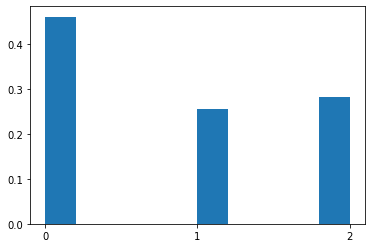

In [1307]:
plt.hist(sorted(matches.OutCome.astype(str)),weights=np.ones(len(matches.OutCome)) / len(matches.OutCome))

The barplot above shows that the fact to play at Home affects the result.
Infact the number of win matches is higher than the loss matches.
That means it is an important feature to consider if we want to predict the final outcome

Text(0.5, 0.98, 'Result by Season')

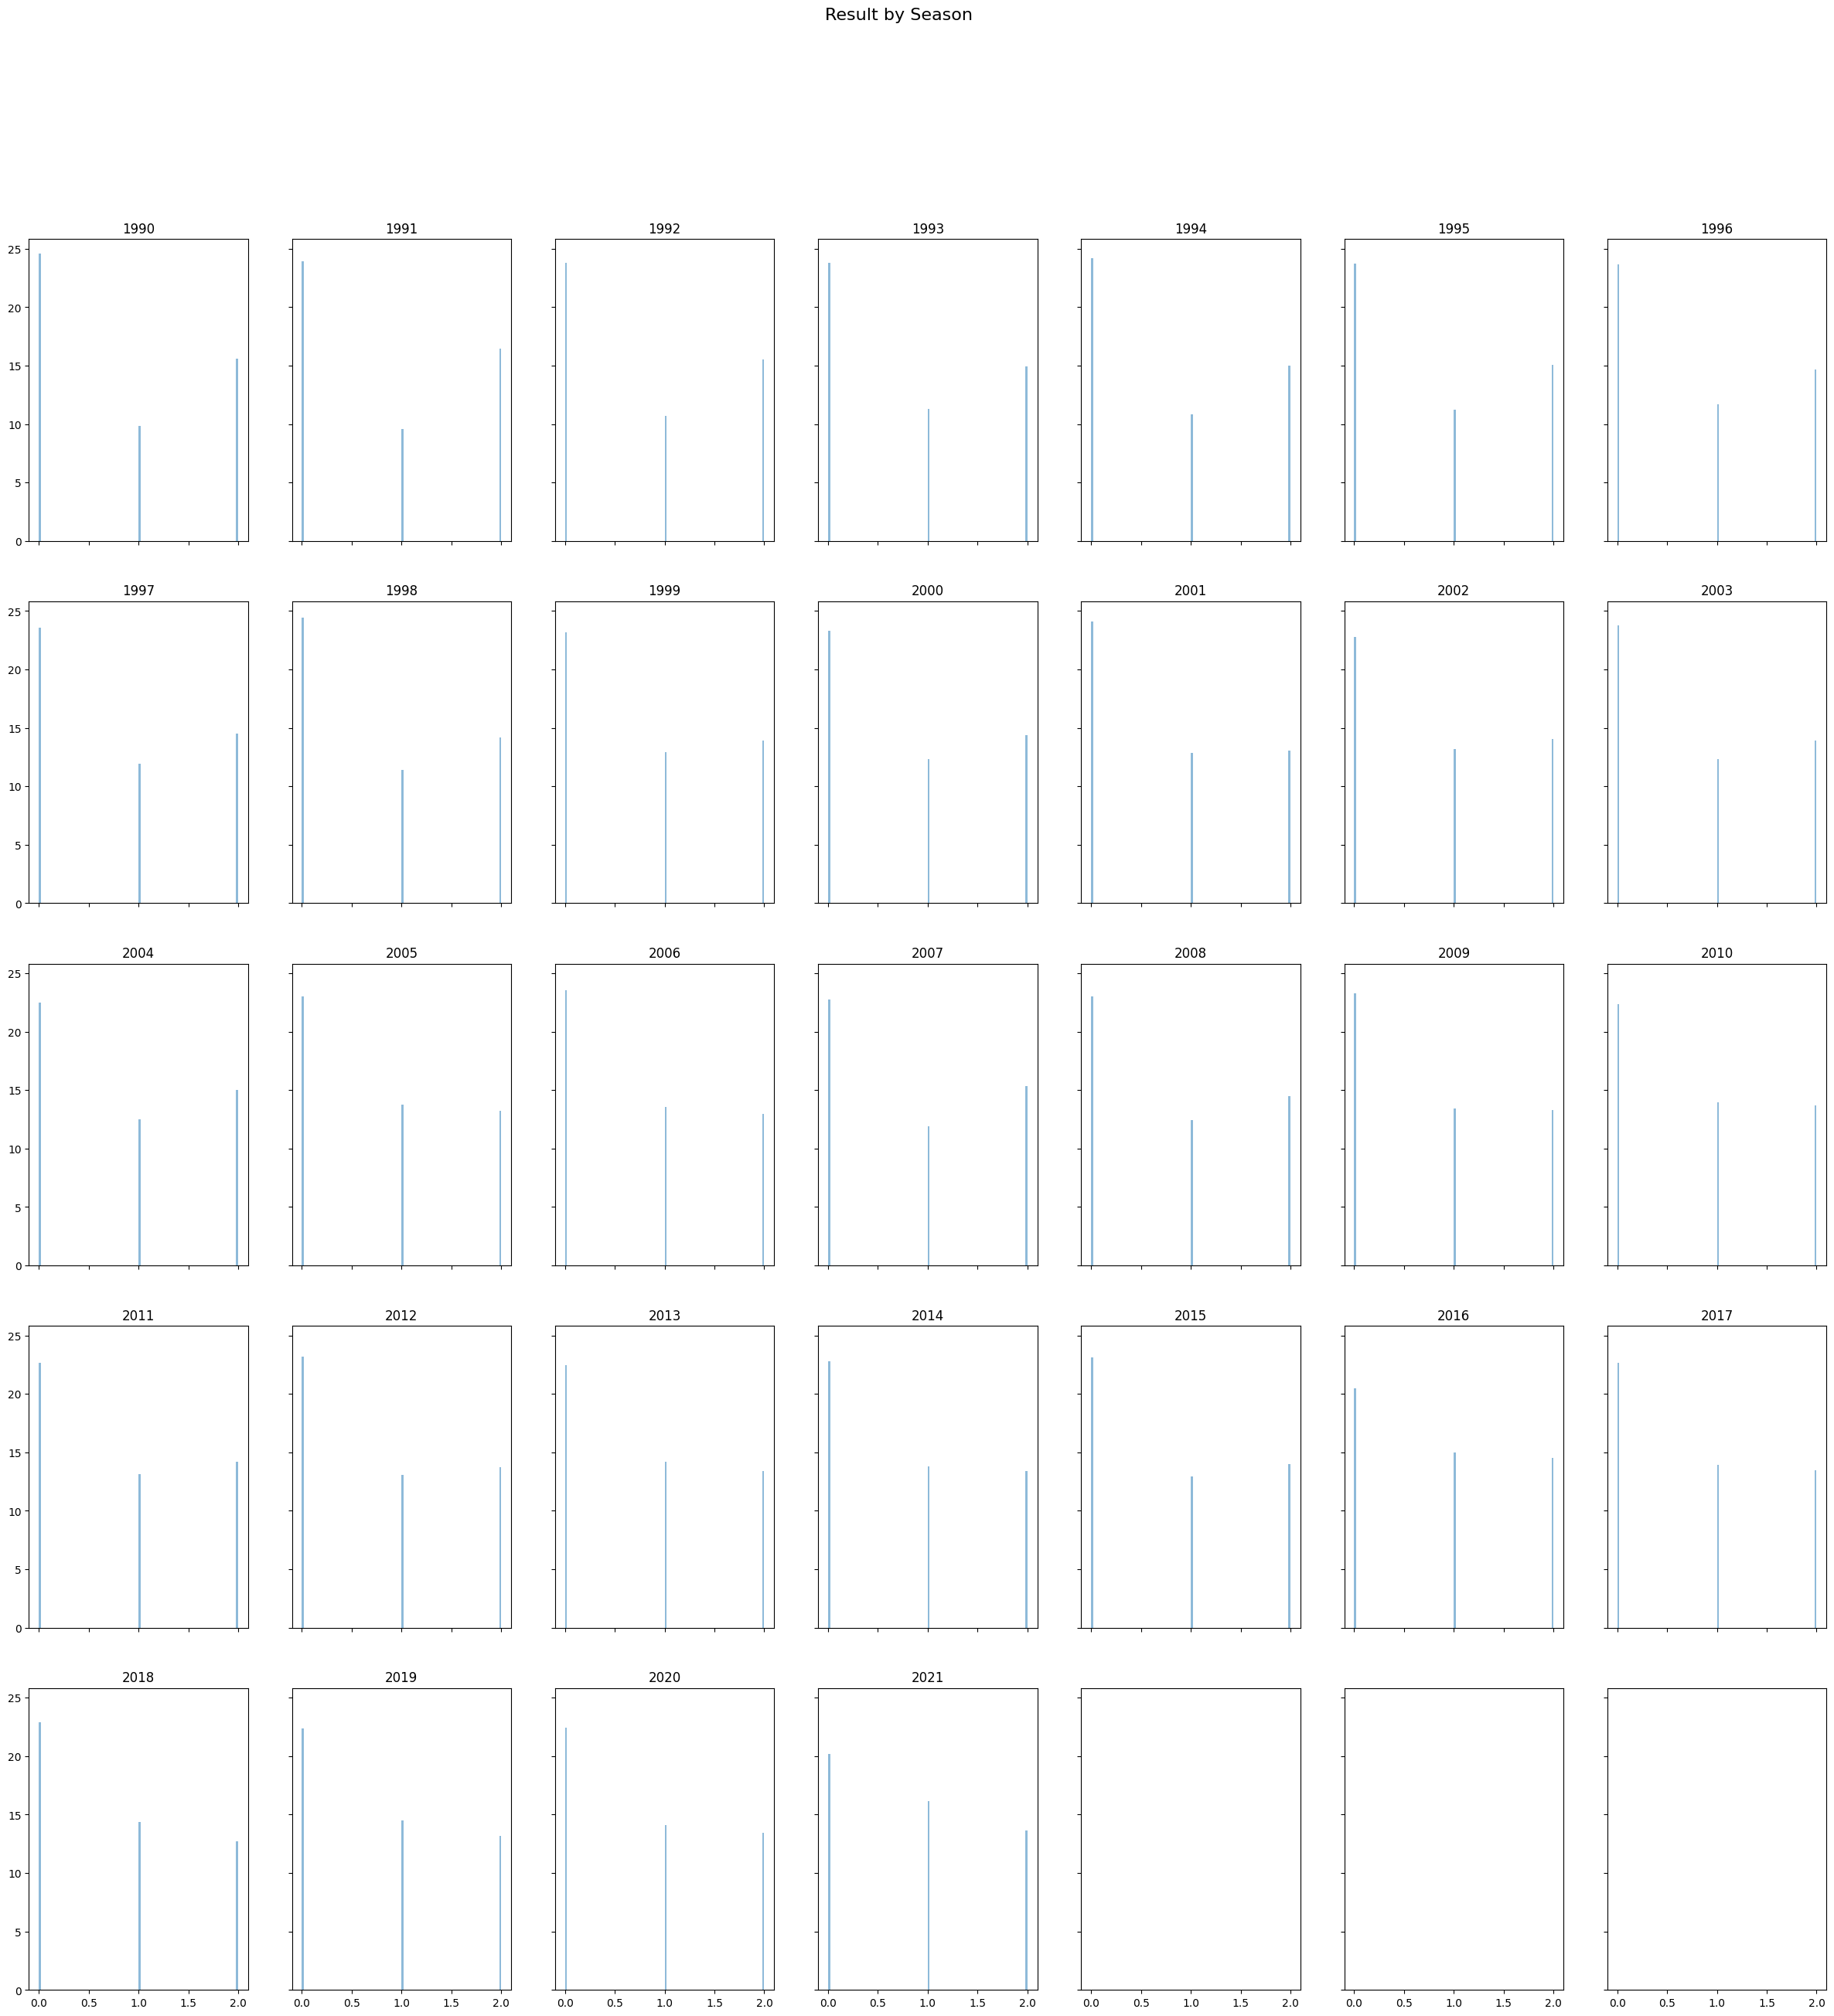

In [1308]:
fig, axes = plt.subplots(5, 7, figsize=(30,30), dpi=100, sharex=True, sharey=True)
for i, (ax, Season) in enumerate(zip(axes.flatten(), matches.Season.unique())):
    x = matches.loc[matches.Season==Season, 'OutCome']
    ax.hist(x, alpha=0.5, bins=100, density=True, stacked=True,label=str(Season))
    ax.set_title(Season)
plt.suptitle('Result by Season', size=16)

Text(0.5, 0.98, 'Result by League')

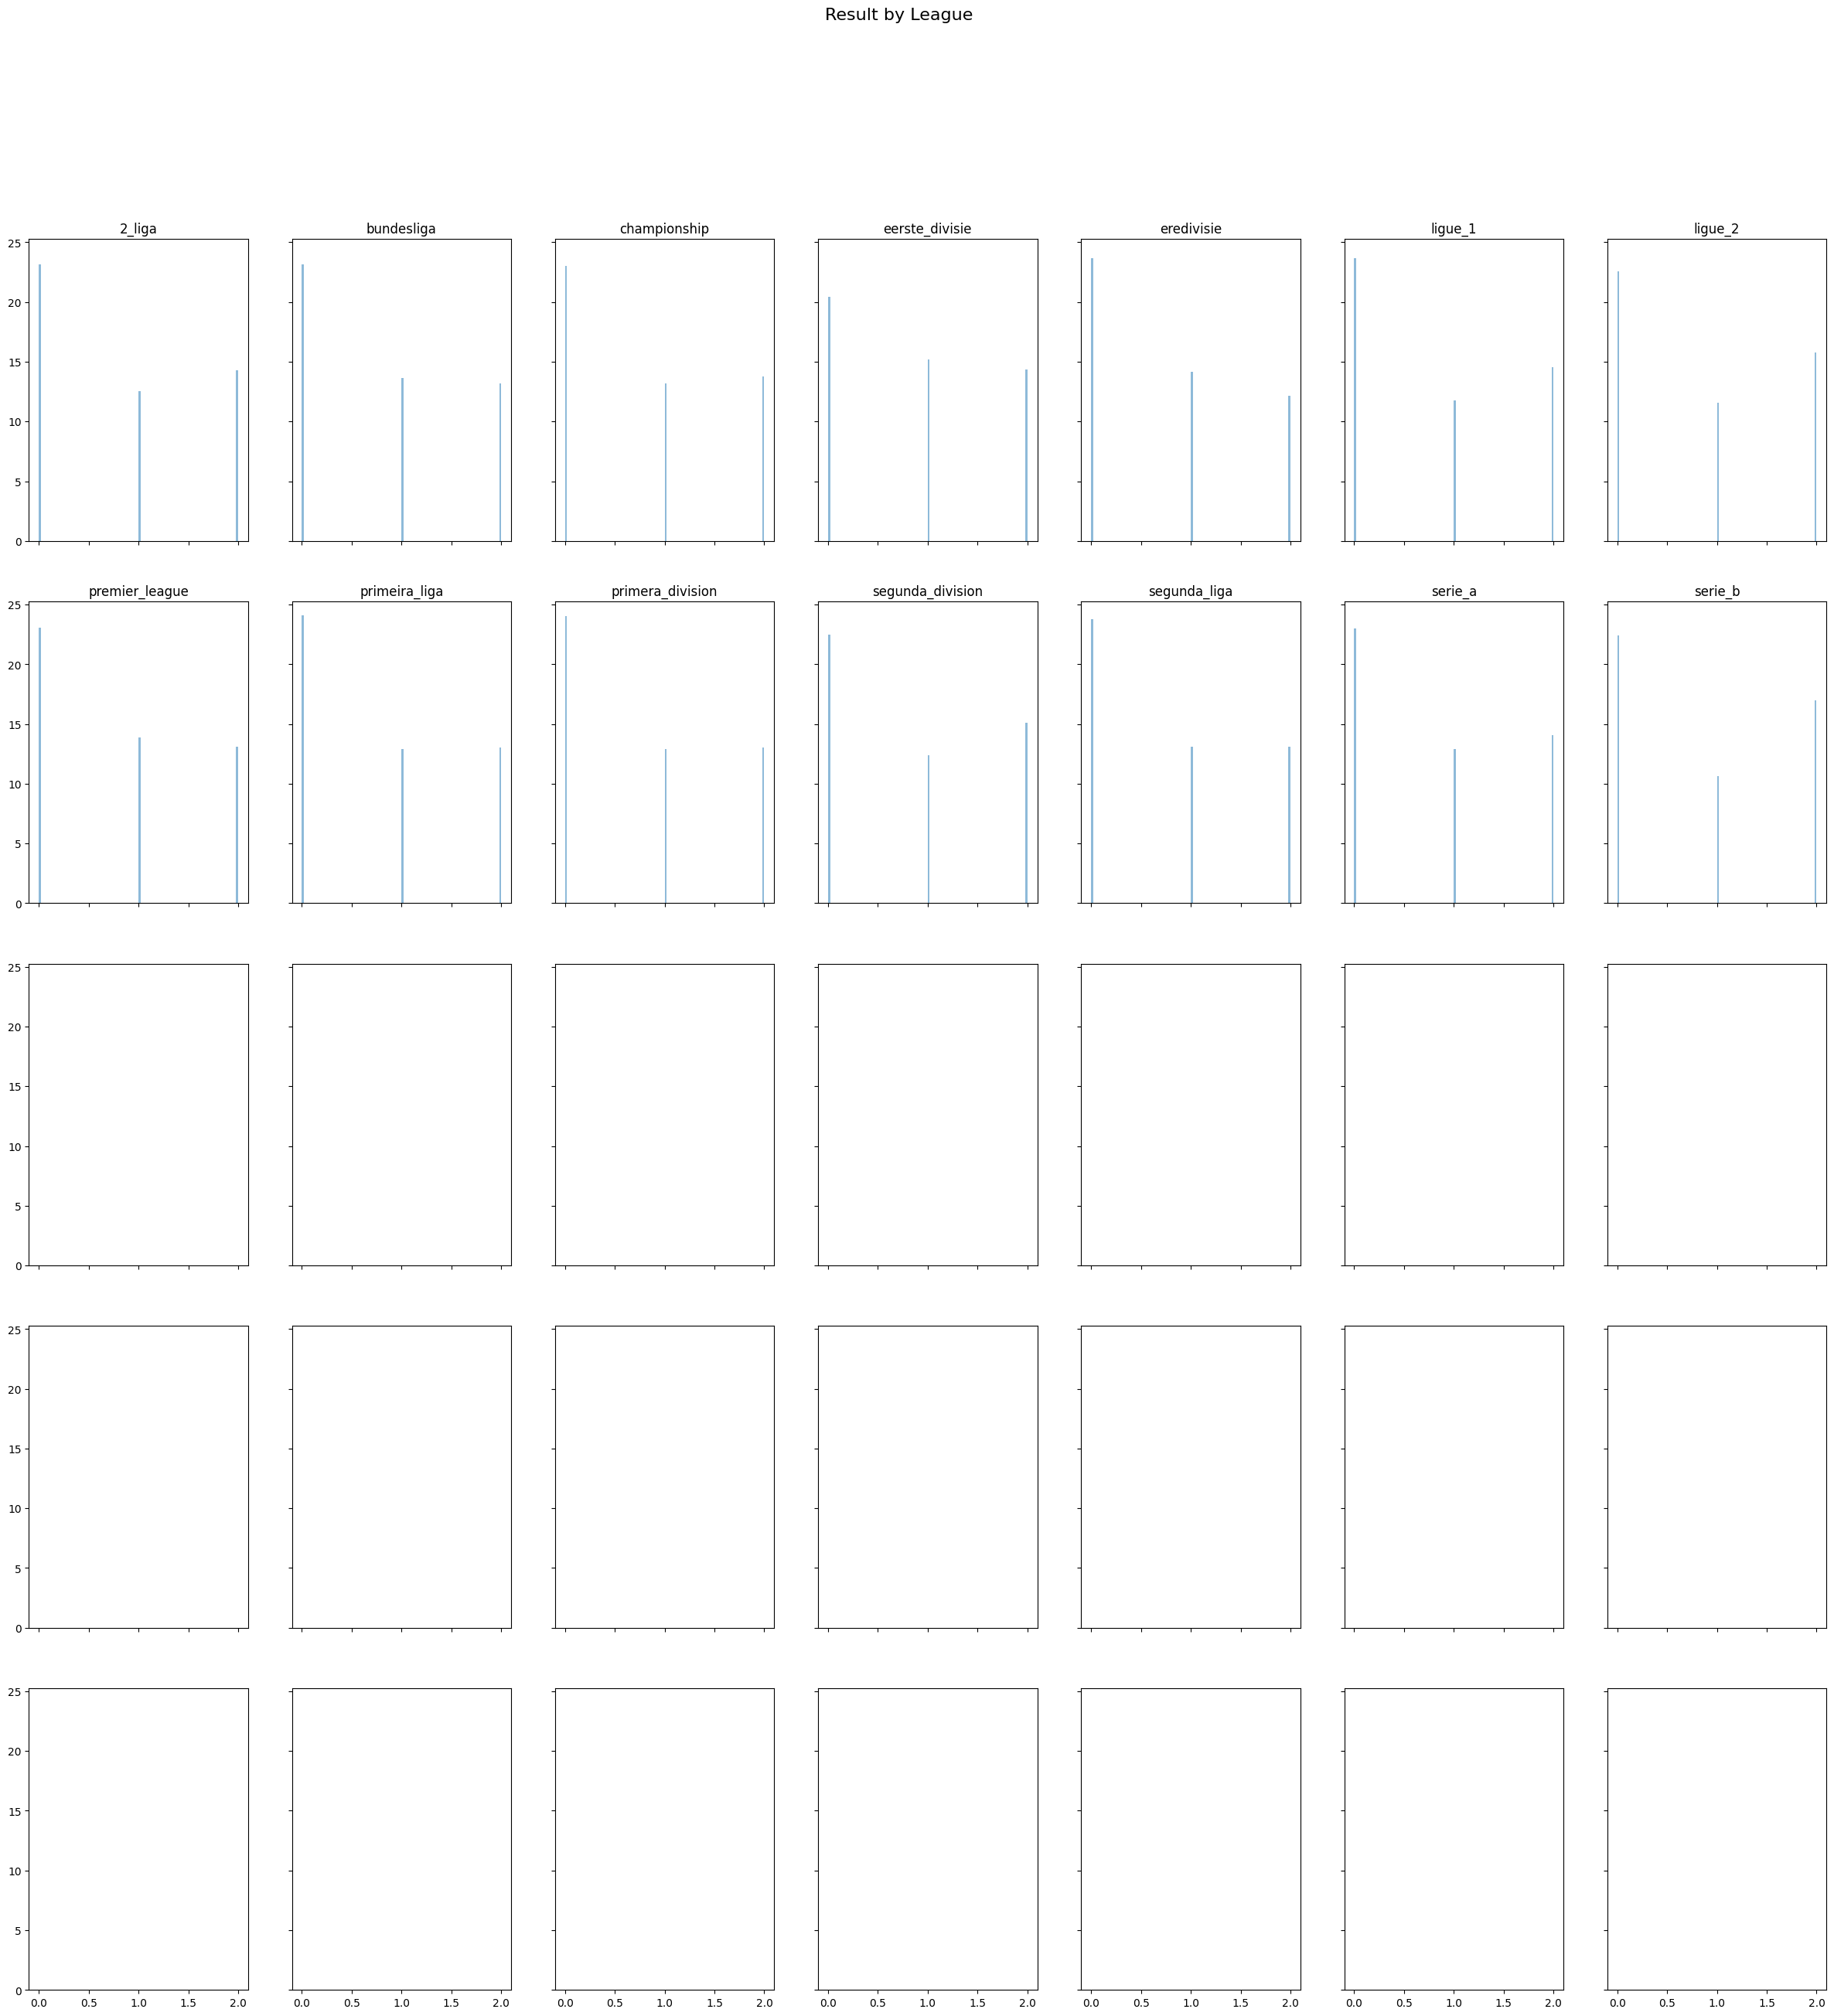

In [1309]:
fig, axes = plt.subplots(5, 7, figsize=(30,30), dpi=100, sharex=True, sharey=True)
for i, (ax, League) in enumerate(zip(axes.flatten(), matches.League.unique())):
    x = matches.loc[matches.League==League, 'OutCome']
    ax.hist(x, alpha=0.5, bins=100, density=True, stacked=True,label=str(League))
    ax.set_title(League)
plt.suptitle('Result by League', size=16)

As the plot shows above,the distribuition of the result change a bit by year in particular it can be a difference between the away wins and the draws.
As the goal is to predict the outcome of the next matches it will be a relevant feature.

In [1310]:
tm = pd.read_csv("DataToAdd/Match_Info.csv")

In [1311]:
ti = pd.read_csv("DataToAdd/Team_Info.csv")

In [1312]:
Elo = pickle.load(open('DataToAdd/elo_dict.pkl', 'rb'))

In [1313]:
matches["ELO_Home"] = matches["Link"].apply(lambda x:Elo[x]["Elo_home"])
matches["ELO_Away"] = matches["Link"].apply(lambda x:Elo[x]["Elo_away"])

In [1314]:
matches["Link"] = matches["Link"].apply(lambda x: x.replace("https://www.besoccer.com",""))
matches["Link"] = matches["Link"].apply(lambda x:x[0:len(x)-4])

In [1315]:
matches = matches.merge(tm, how='left', on='Link')
ti=ti.rename(columns={"Team":"Home_Team"})
matches = matches.merge(ti, how='left', on='Home_Team')

In [1316]:
matches.drop('City',inplace=True,axis = 1)
matches.drop('Link',inplace=True,axis = 1)
matches.drop('Round',inplace=True,axis = 1)
matches.drop('Country',inplace=True,axis = 1)
matches.drop('Referee',inplace=True,axis = 1)
matches.drop('Stadium',inplace=True,axis = 1)
matches.drop('Date_New',inplace=True,axis = 1)

In [1317]:
# get the data for different groups
matches['Capacity'] = matches['Capacity'].astype(str)
matches['Capacity'] = matches['Capacity'].apply(lambda x: x.replace(",",""))
matches['Capacity'] = matches['Capacity'].astype(float)
matches['Capacity'] = matches['Capacity'].fillna(matches['Capacity'].median())

In [1318]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146492 entries, 0 to 146491
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Home_Team    146492 non-null  object 
 1   Away_Team    146492 non-null  object 
 2   Result       146492 non-null  object 
 3   Season       146492 non-null  object 
 4   League       146492 non-null  object 
 5   OutCome      146492 non-null  object 
 6   ELO_Home     134869 non-null  float64
 7   ELO_Away     134869 non-null  float64
 8   Home_Yellow  42188 non-null   float64
 9   Home_Red     42188 non-null   float64
 10  Away_Yellow  42188 non-null   float64
 11  Away_Red     42188 non-null   float64
 12  Capacity     146492 non-null  float64
 13  Pitch        131851 non-null  object 
dtypes: float64(7), object(7)
memory usage: 16.8+ MB


<AxesSubplot:>

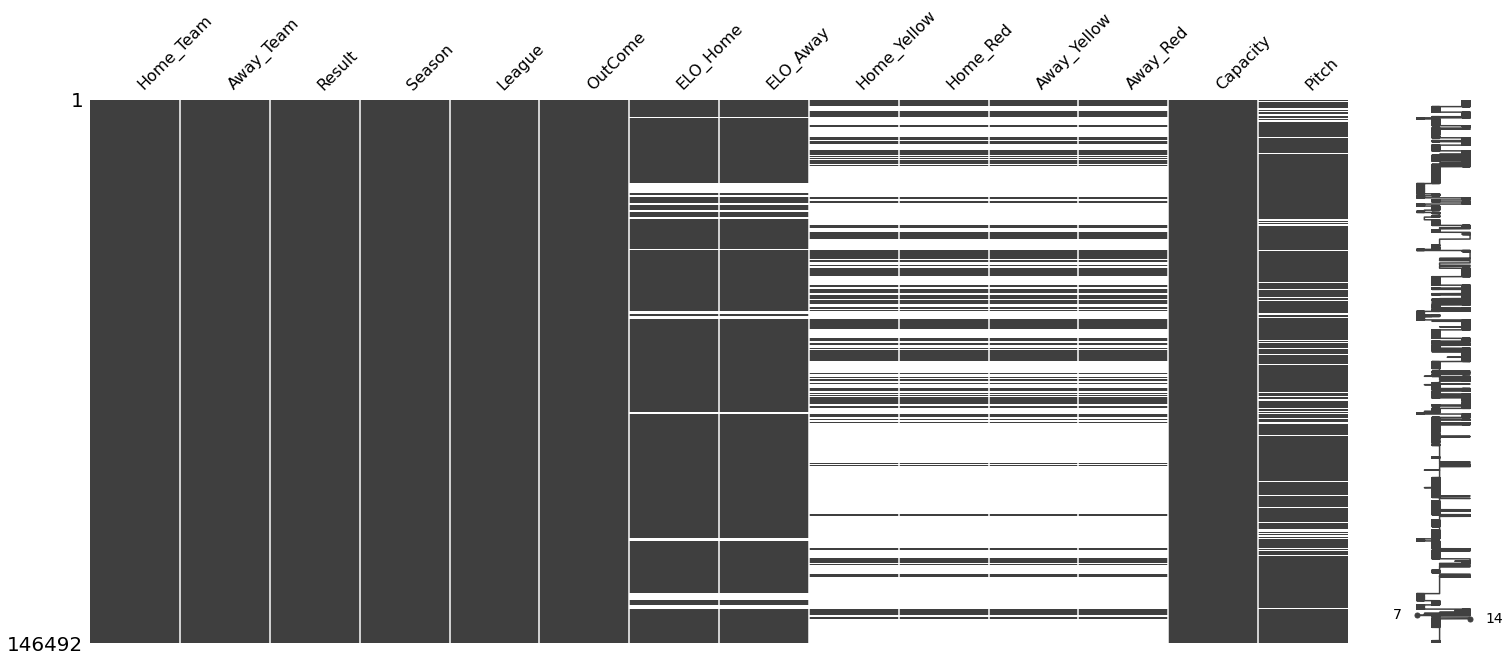

In [1319]:
msn.matrix(matches)

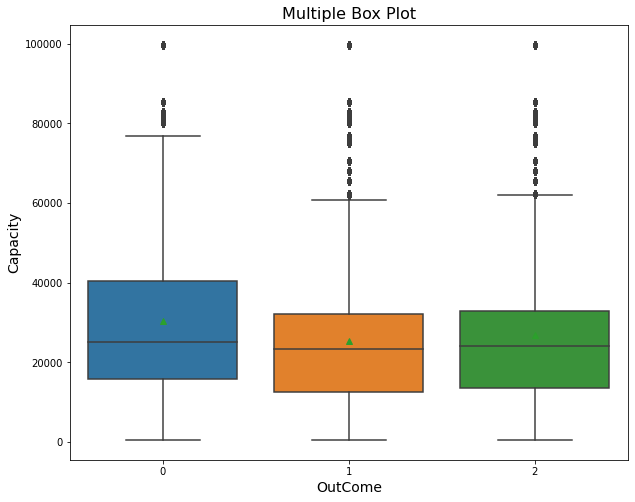

In [1320]:
matches = matches[matches['ELO_Home'].notna()]
matches = matches[matches['ELO_Away'].notna()]
# plot the figure
plt.figure(figsize=(10, 8))
sns.boxplot(x='OutCome',
            y='Capacity',
            data=matches,
            showmeans=True)
plt.title("Multiple Box Plot", fontsize=16)
plt.xlabel("OutCome", fontsize=14)
plt.ylabel("Capacity", fontsize=14)
plt.savefig("box_mat6")
plt.show()


As the boxplots show above Result is not indipendent from the Capacity.
The mean is not equal in the different groups and that means that the capacity can affect the result that we want to predict.

In [1321]:
matches.Pitch.fillna(matches.Pitch.mode()[0], inplace=True)
matches.Pitch = matches.Pitch.str.lower()
matches.Pitch = matches.Pitch.replace(['césped'],'natural')
matches.Pitch = matches.Pitch.replace(['cesped natural'],'natural')
matches.Pitch = matches.Pitch.replace(['césped natural'],'natural')
matches.Pitch = matches.Pitch.replace(['cesped real'],'natural')
matches.Pitch = matches.Pitch.replace(['natural'],'grass')
matches.Pitch = matches.Pitch.replace(['natural grass'],'grass')

matches.Pitch.unique()

array(['grass', 'césped artificial', 'airfibr ', 'artificial'],
      dtype=object)

(array([2.63218382e-03, 0.00000000e+00, 0.00000000e+00, 3.11413297e-04,
        0.00000000e+00, 0.00000000e+00, 3.09411355e-02, 0.00000000e+00,
        0.00000000e+00, 9.66115267e-01]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

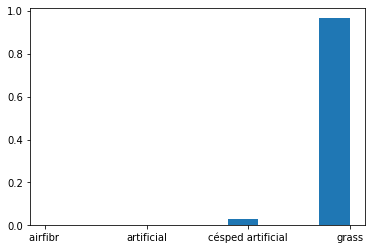

In [1322]:
plt.hist(sorted(matches.Pitch),weights=np.ones(len(matches.Pitch)) / len(matches.Pitch))

Pitch is quite unbalanced toward grass so it will not be a relevant feature

In [1323]:
matches.drop('Pitch',inplace=True,axis = 1)

What about Elo? It is intuitive that the more a team has a higher Elo more likely it will win.
Let's create a value DifferenceElo and draw a plot

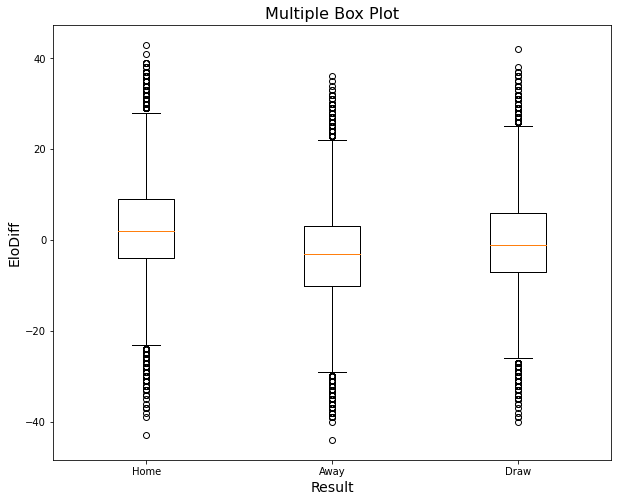

In [1324]:
homeWin = matches[matches['OutCome']==0]
awayWin = matches[matches['OutCome']==1]
draw = matches[matches['OutCome']==2]
home = homeWin["ELO_Home"] - homeWin["ELO_Away"]
away= awayWin["ELO_Home"] - awayWin["ELO_Away"]
draw = draw["ELO_Home"] - draw["ELO_Away"]
data = [home,away,draw]
labels = ['Home','Away','Draw']
# plot the figure
plt.figure(figsize=(10, 8))
plt.boxplot(data, labels=labels)
plt.title("Multiple Box Plot", fontsize=16)
plt.xlabel("Result", fontsize=14)
plt.ylabel("EloDiff", fontsize=14)
plt.savefig("box_mat6")
plt.show()

The plot show that when a team wins at home has probably a higher ELO and the same when it wins away.
The median for draws is close to 0 as we expected.

In [1325]:
matches['Home_Yellow'] = matches['Home_Yellow'].fillna(0)
matches['Home_Red'] = matches['Home_Red'].fillna(0)
matches['Away_Yellow'] = matches['Away_Yellow'].fillna(0)
matches['Away_Red'] = matches['Away_Red'].fillna(0)

MODEL PERFORMING
Let's train a simple model in order to see the initial score

In [1326]:
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [1327]:
categorical_features = ['League']
matchesFirstModel = matches.copy()
matchesFirstModel.drop('Result',inplace=True,axis = 1)


In [1328]:
for c_feature in categorical_features:
  matchesFirstModel = create_dummies( matchesFirstModel, c_feature )

In [1329]:
matchesFirstModel.drop('Home_Team',inplace=True,axis = 1)
matchesFirstModel.drop('Away_Team',inplace=True,axis = 1)
nCols = matchesFirstModel.shape[1] -1
column_to_move = matchesFirstModel.pop("OutCome")
matchesFirstModel.insert(nCols, "OutCome", column_to_move)

In [1330]:
from sklearn.model_selection import train_test_split

matchesFirstModel = matchesFirstModel.dropna()
train_X, test_X, train_y, test_y = train_test_split( matchesFirstModel.iloc[:, 0:nCols],
                                                  matchesFirstModel['OutCome'],
                                                  test_size = 0.2,
                                                  random_state = 42 )
train_y=train_y.astype('int')
test_y=test_y.astype('int')

ss = StandardScaler()
X_train = ss.fit_transform(train_X)
X_test = ss.transform(test_X)

In [1331]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(train_X, train_y)
logreg.coef_[0]

array([ 1.08651200e-04,  2.87747686e-02, -2.77109583e-02, -4.86693359e-04,
       -2.51292331e-04,  4.81753574e-04,  3.27955771e-04,  2.80116094e-06,
       -1.36283985e-04, -1.44789856e-04, -3.32245152e-05, -7.10481835e-05,
        2.47336657e-04,  1.37346019e-04, -3.70662064e-05, -1.18372524e-04,
        2.34332936e-04,  8.51222714e-05, -3.27953689e-05,  1.77416122e-04,
       -1.37318598e-04, -1.65778263e-04])

In [1332]:
from sklearn import metrics
y_pred=logreg.predict(test_X)
cnf_matrix = metrics.confusion_matrix(test_y, y_pred)
print(cnf_matrix)

[[11094  1047   240]
 [ 5122  1699   141]
 [ 6352  1111   168]]


In [1333]:
print("Accuracy:",metrics.accuracy_score(test_y, y_pred))
print("Precision:",metrics.precision_score(test_y, y_pred,average='micro'))
print("Recall:",metrics.recall_score(test_y, y_pred,average='micro'))

Accuracy: 0.48049974049084304
Precision: 0.48049974049084304
Recall: 0.48049974049084304


The result is better than a random classifier.
As the confusion matrix shows the models is skewed toward HomeWin too much.
Let'see what happen to the train testing in order to see if it underfitting or not

In [1219]:
y_pred=logreg.predict(train_X)
cnf_matrix = metrics.confusion_matrix(train_y, y_pred)
print(cnf_matrix)

[[44681  4200   952]
 [20500  6705   597]
 [25342  4245   673]]


In [1220]:
print("Accuracy:",metrics.accuracy_score(train_y, y_pred))
print("Precision:",metrics.precision_score(train_y, y_pred,average='micro'))
print("Recall:",metrics.recall_score(train_y, y_pred,average='micro'))

Accuracy: 0.4824968719588489
Precision: 0.4824968719588489
Recall: 0.4824968719588489


The result is the same and it leads to conclude that the model is not overfitting.
So probably we have to add new features in order to add new information to the model
Let's see by random forest the feature importance in order to get any hint

In [1221]:
randomForest = sklearn.ensemble.RandomForestClassifier(n_estimators=30,random_state=42)
randomForest.fit(train_X, train_y)
predictions = randomForest.predict(test_X)

Text(0.5, 0, 'Feature Importance')

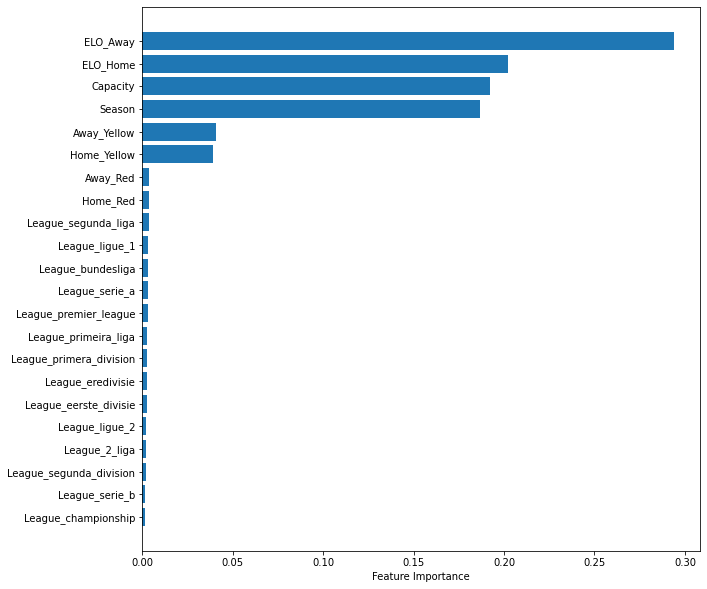

In [1222]:
sort = randomForest.feature_importances_.argsort()
plt.figure(figsize=(10, 10))
plt.barh(matchesFirstModel.columns[sort], randomForest.feature_importances_[sort])
plt.xlabel("Feature Importance")

It seems that the most important features are linked to performance of the teams rather than general conditions like Capacity or League.
An idea is to take in account other factors about the performance of the teams along the season like goals and yellow or red card


In [1223]:
nCol=len(matches.columns)
matches.insert(nCol, 'Goal_Scored_HomeTeam', 0)


In [1224]:
nCol=len(matches.columns)
matches.insert(nCol, 'Goal_Collected_HomeTeam', 0)

In [1225]:
nCol=len(matches.columns)
matches.insert(nCol, 'Goal_Scored_AwayTeam', 0)

In [1226]:
nCol=len(matches.columns)
matches.insert(nCol, 'Goal_Collected_AwayTeam', 0)

In [1227]:
nCol=len(matches.columns)
matches.insert(nCol, 'Yellow_Collected_HomeTeam', 0)

In [1228]:
nCol=len(matches.columns)
matches.insert(nCol, 'Red_Collected_HomeTeam', 0)

In [1229]:
nCol=len(matches.columns)
matches.insert(nCol, 'Yellow_Collected_AwayTeam', 0)

In [1230]:
nCol=len(matches.columns)
matches.insert(nCol, 'Red_Collected_AwayTeam', 0)

In [1231]:
currentSeason = matches.iloc[0]["Season"]
currentLeague = matches.iloc[0]["League"]
TeamDesc = {}

In [1232]:
class Team:
  def __init__(self, goalScored, goalCollected, redCards, yellowCards):
    self.goalScored = goalScored
    self.goalCollected = goalCollected
    self.redCards = redCards
    self.yellowCards = yellowCards

In [1233]:
def AddMatch(HomeTeam,AwayTeam,GoalHome,GoalAway,YellowHome,RedHome,YellowAway,RedAway):
    if HomeTeam in TeamDesc:
        homeTeam = TeamDesc[HomeTeam]
        homeTeam.goalScored = homeTeam.goalScored + GoalHome
        homeTeam.goalCollected = homeTeam.goalCollected + GoalAway
        homeTeam.redCards = homeTeam.redCards + RedHome
        homeTeam.yellowCards = homeTeam.yellowCards + YellowHome
    else:
        homeTeam = Team(GoalHome,GoalAway,YellowHome,RedHome)
        TeamDesc[HomeTeam] = homeTeam
        
    if AwayTeam in TeamDesc:
        awayTeam = TeamDesc[AwayTeam]
        awayTeam.goalScored = awayTeam.goalScored + GoalAway
        awayTeam.goalCollected = awayTeam.goalCollected + GoalHome
        awayTeam.redCards = awayTeam.redCards + RedAway
        awayTeam.yellowCards = awayTeam.yellowCards + YellowAway
    else:
        awayTeam = Team(GoalAway,GoalHome,YellowAway,RedAway)
        TeamDesc[AwayTeam] = awayTeam
    

In [1234]:
def UpdateTeamDesc(match):
    global currentSeason
    global TeamDesc
    season = match["Season"]
    if season != currentSeason:
        TeamDesc = {}
        currentSeason=season
    goals = match.Result.split("-")
    homeGoals = int(goals[0])
    awayGoals = int(goals[1])
    if match["Home_Team"] in TeamDesc.keys():
        match["Goal_Scored_HomeTeam"] =  TeamDesc[match["Home_Team"]].goalScored
        match["Goal_Collected_HomeTeam"] =  TeamDesc[match["Home_Team"]].goalCollected
        match["Yellow_Collected_HomeTeam"] =  TeamDesc[match["Home_Team"]].yellowCards
        match["Red_Collected_HomeTeam"] =  TeamDesc[match["Home_Team"]].redCards
    else:
        match["Goal_Scored_HomeTeam"] = 0
        match["Goal_Collected_HomeTeam"] = 0 
        match["Yellow_Collected_HomeTeam"] = 0
        match["Red_Collected_HomeTeam"] = 0 

    if match["Away_Team"] in TeamDesc.keys():
        match["Goal_Scored_AwayTeam"] =  TeamDesc[match["Away_Team"]].goalScored
        match["Goal_Collected_AwayTeam"] =  TeamDesc[match["Away_Team"]].goalCollected
        match["Yellow_Collected_AwayTeam"] =  TeamDesc[match["Away_Team"]].yellowCards
        match["Red_Collected_AwayTeam"] =  TeamDesc[match["Away_Team"]].redCards
    else:
        match["Goal_Scored_AwayTeam"] = 0
        match["Goal_Collected_AwayTeam"] = 0   
        match["Yellow_Collected_AwayTeam"] = 0
        match["Red_Collected_AwayTeam"] = 0    
           
    AddMatch(match["Home_Team"],match["Away_Team"],homeGoals,awayGoals,match.Home_Yellow,match.Home_Red,match.Away_Yellow,match.Away_Red)    
    return match

In [1235]:
matches = matches.apply(UpdateTeamDesc,axis=1)

In [1236]:
matches.drop('Home_Team',inplace=True,axis = 1)
matches.drop('Away_Team',inplace=True,axis = 1)
matches.drop('Result',inplace=True,axis = 1)

In [1237]:
for c_feature in categorical_features:
  matches = create_dummies( matches, c_feature )

In [1238]:
nCols = matches.shape[1] -1
column_to_move = matches.pop("OutCome")
matches.insert(nCols, "OutCome", column_to_move)

In [1239]:
from sklearn.model_selection import train_test_split

matches = matches.dropna()
train_X, test_X, train_y, test_y = train_test_split( matches.iloc[:, 0:nCols],
                                                  matches['OutCome'],
                                                  test_size = 0.2,
                                                  random_state = 42 )
train_y=train_y.astype('int')
test_y=test_y.astype('int')
ss = StandardScaler()
X_train = ss.fit_transform(train_X)
X_test = ss.transform(test_X)

In [1240]:
test_X

,Season,ELO_Home,ELO_Away,Home_Yellow,Home_Red,Away_Yellow,Away_Red,Capacity,Goal_Scored_HomeTeam,Goal_Collected_HomeTeam,...,League_eredivisie,League_ligue_1,League_ligue_2,League_premier_league,League_primeira_liga,League_primera_division,League_segunda_division,League_segunda_liga,League_serie_a,League_serie_b
64592,2012,61.0,64.0,2.0,0.0,2.0,0.0,25064.0,25,28,...,0,0,1,0,0,0,0,0,0,0
37247,1994,78.0,82.0,0.0,0.0,2.0,0.0,28278.0,58,32,...,1,0,0,0,0,0,0,0,0,0
13970,2002,79.0,73.0,3.0,0.0,3.0,1.0,57030.0,29,35,...,0,0,0,0,0,0,0,0,0,0
139979,2007,42.0,61.0,0.0,0.0,0.0,0.0,16227.0,9,7,...,0,0,0,0,0,0,0,0,0,1
138495,2004,47.0,62.0,3.0,1.0,2.0,0.0,10215.0,6,7,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137681,2002,56.0,43.0,4.0,0.0,2.0,0.0,36703.0,1,2,...,0,0,0,0,0,0,0,0,0,1
55379,2017,81.0,68.0,0.0,0.0,0.0,0.0,49834.0,7,14,...,0,1,0,0,0,0,0,0,0,0
16322,2010,66.0,83.0,0.0,0.0,0.0,0.0,21000.0,19,9,...,0,0,0,0,0,0,0,0,0,0
105844,2000,51.0,58.0,0.0,0.0,0.0,0.0,33732.0,1,2,...,0,0,0,0,0,0,1,0,0,0


In [1241]:
logreg.fit(train_X, train_y)
logreg.coef_[0]
y_pred=logreg.predict(test_X)
cnf_matrix = metrics.confusion_matrix(test_y, y_pred)
print(cnf_matrix)

[[10744  1179   458]
 [ 4046  2250   666]
 [ 6001  1172   458]]


c:\progetti Python\Football Match Outcome Prediction\AiCoreFootballProject\Football-Match-Outcome-Prediction\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [1242]:
print("Accuracy:",metrics.accuracy_score(test_y, y_pred))
print("Precision:",metrics.precision_score(test_y, y_pred)
print("Recall:",metrics.recall_score(test_y, y_pred)

Accuracy: 0.4987024542151702
Precision: 0.4987024542151702
Recall: 0.4987024542151702


In [1243]:
adaBoost = sklearn.ensemble.AdaBoostClassifier()
adaBoost.fit(train_X, train_y)
predictions = adaBoost.predict(test_X)

In [1244]:
print("Accuracy:",metrics.accuracy_score(test_y, predictions))
print("Precision:",metrics.precision_score(test_y, predictions,average='micro'))
print("Recall:",metrics.recall_score(test_y, predictions,average='micro'))

Accuracy: 0.524579224438348
Precision: 0.524579224438348
Recall: 0.524579224438348


In [1245]:
cnf_matrix = metrics.confusion_matrix(test_y, predictions)
print(cnf_matrix)

[[10864  1222   295]
 [ 4159  2426   377]
 [ 5555  1216   860]]


In [1246]:
randomForest = sklearn.ensemble.RandomForestClassifier(n_estimators=30,random_state=42)
randomForest.fit(train_X, train_y)
predictions = randomForest.predict(test_X)

Text(0.5, 0, 'Feature Importance')

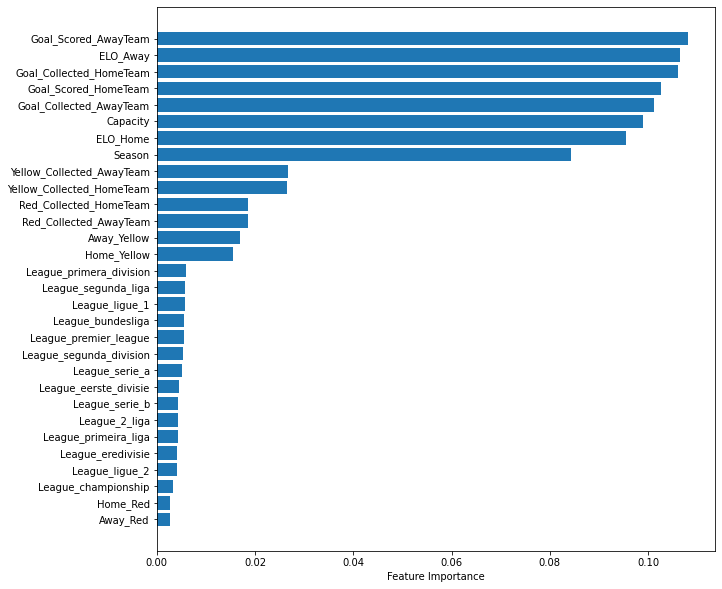

In [1247]:
sort = randomForest.feature_importances_.argsort()
plt.figure(figsize=(10, 10))
plt.barh(matches.columns[sort], randomForest.feature_importances_[sort])
plt.xlabel("Feature Importance")

In [1248]:
print("Accuracy:",metrics.accuracy_score(test_y, predictions))
print("Precision:",metrics.precision_score(test_y, predictions,average='micro'))
print("Recall:",metrics.recall_score(test_y, predictions,average='micro'))

Accuracy: 0.5175354044635575
Precision: 0.5175354044635575
Recall: 0.5175354044635575


In [1249]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(adaBoost, matches.iloc[:, 0:nCols],matches['OutCome'], scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.522 (0.005)


In [1250]:
matches1990 = matches[matches['Season'] <=2000]
matches2000 = matches.query('Season > 2000 and Season <=2010') 
matches2010 = matches.query('Season > 2010') 

In [1251]:
train1990_X, test1990_X, train1990_y, test1990_y = train_test_split( matches1990.iloc[:, 0:nCols],
                                                  matches1990['OutCome'],
                                                  test_size = 0.2,
                                                  random_state = 42 )

In [1252]:
train2000_X, test2000_X, train2000_y, test2000_y = train_test_split( matches2000.iloc[:, 0:nCols],
                                                  matches2000['OutCome'],
                                                  test_size = 0.2,
                                                  random_state = 42 )

In [1253]:
train2010_X, test2010_X, train2010_y, test2010_y = train_test_split( matches2010.iloc[:, 0:nCols],
                                                  matches2010['OutCome'],
                                                  test_size = 0.2,
                                                  random_state = 42 )

In [1254]:
adaBoost1990 = sklearn.ensemble.AdaBoostClassifier()
adaBoost2000 = sklearn.ensemble.AdaBoostClassifier()
adaBoost2010 = sklearn.ensemble.AdaBoostClassifier()

#adaBoost1990.fit(train1990_X, train1990_y)
#predictions1990 = adaBoost1990.predict(test1990_X)

#adaBoost2000.fit(train2000_X, train2000_y)
#predictions2000 = adaBoost2000.predict(test2000_X)

#adaBoost2010.fit(train2010_X, train2010_y)
#predictions2010 = adaBoost2010.predict(test2010_X)

In [1255]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(adaBoost1990, matches1990.iloc[:, 0:nCols],matches1990['OutCome'], scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.508 (0.005)


In [1256]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(adaBoost2000, matches2000.iloc[:, 0:nCols],matches2000['OutCome'], scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.524 (0.005)


In [1257]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(adaBoost2010, matches2010.iloc[:, 0:nCols],matches2010['OutCome'], scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.529 (0.009)


In [1261]:
# define the grid of values to search
adaBoost2010 = sklearn.ensemble.AdaBoostClassifier()
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=adaBoost2010, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(matches2010.iloc[:, 0:nCols], matches2010['OutCome'])
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.538479 using {'learning_rate': 0.1, 'n_estimators': 500}
0.450005 (0.009187) with: {'learning_rate': 0.0001, 'n_estimators': 10}
0.452567 (0.011095) with: {'learning_rate': 0.0001, 'n_estimators': 50}
0.453827 (0.012117) with: {'learning_rate': 0.0001, 'n_estimators': 100}
0.464488 (0.013259) with: {'learning_rate': 0.0001, 'n_estimators': 500}
0.453652 (0.011897) with: {'learning_rate': 0.001, 'n_estimators': 10}
0.464488 (0.013259) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.474918 (0.003129) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.474776 (0.003053) with: {'learning_rate': 0.001, 'n_estimators': 500}
0.475006 (0.003271) with: {'learning_rate': 0.01, 'n_estimators': 10}
0.474810 (0.003072) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.475457 (0.003112) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.496244 (0.003248) with: {'learning_rate': 0.01, 'n_estimators': 500}
0.475498 (0.003029) with: {'learning_rate': 0.1, 'n_estimators': 10}
0.497424

In [ ]:
#pre_process = ColumnTransformer(remainder='passthrough',
                                #transformers=[('drop_columns', 'drop', ['Link',
                                                                        #'Round',
                                                                        #'Country',
                                                                        #'Stadium',
                                                                        #'Referee',
                                                                        #'Date_New',
                                                                        #'City'
                                                                       ]),
                                              #('fill_capacity', SimpleImputer(strategy='median'), ['Capacity']),
                                              
                                              #('scale_data', StandardScaler(),['Item_MRP'])])


In [ ]:
#model_pipeline = Pipeline(steps=[('get_outlet_binary_columns', OutletTypeEncoder()), 
                                 #('pre_processing',pre_process),
                                # ('random_forest', RandomForestRegressor(max_depth=10,random_state=2))
                                #])